# Классификация: в хиджабе / не в хиджабе

классификация изображений с помощью передачи обучения из предварительно обученной сети 
#### при получении изображений из различных директорий

In [2]:
#подгружаем пакет, собирающий все изображения по директориям, и адаптирующий их к использованию вместе с классами, 
# и в конечном счете  преобразующий все изображения в тестовый и тренировочный наборы tf.data.Dataset
from custom_import_from_directory import custom

import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os

#Используем буферизованную предварительную выборку для загрузки изображений с диска без блокировки ввода-вывода
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Предварительная обработка данных

### Загрузка данных

Загружаем и извлекаем zip-файл, содержащий изображения, расположенные в нескольких директориях

In [3]:
data_root = tf.keras.utils.get_file(origin='https://github.com/najcardboyz/naja-dataset/archive/master.zip',
                                         fname='naja-dataset-master.zip', extract=True)
data_root = os.path.join(os.path.dirname(data_root), 'naja-dataset-master')
data_root_orig = pathlib.Path(data_root)

In [4]:
data_root_orig

PosixPath('/Users/natalaurina/.keras/datasets/naja-dataset-master')

заранее подготавливаем информацию о классах, перечислив их в переменной.                 
в нашем случае всего два класса: в хиджабе/без                   
также определяем размер пакета для загрузки изображений и параметры самих изображений для корректной обработки

In [5]:
class_names = ['nonhijab', 'hijab']
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

подгружаем подготовленные тренировочный и тестовый наборы из пакета, собирающего все изображения по директориям и преобразующего все изображения в эти наборы tf.data.Dataset

In [6]:
train_dataset, validation_dataset = custom(
    class_names = class_names,
    data_root_orig = data_root_orig,
    batch = BATCH_SIZE,
    image_size = IMG_SIZE
)

посмотрим на первые девять изображений и меток из обучающего набора

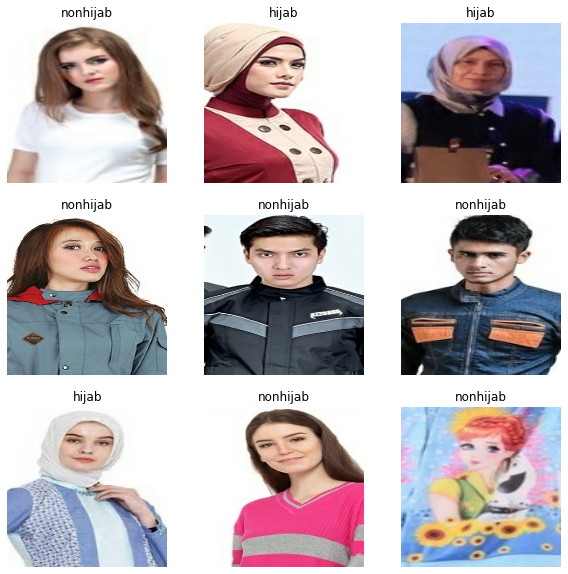

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

создадим тестовый набор.         
Для этого определим, сколько пакетов данных доступно в наборе проверки, используя tf.data.experimental.cardinality ,           
а затем переместим 20% из них в набор тестов.

In [8]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [9]:
print('Количество validation пакетов: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Количество test пакетов: %d' % tf.data.experimental.cardinality(test_dataset))

Количество validation пакетов: 4937
Количество test пакетов: 1234


### Настроем набор данных для повышения производительности

Используем буферизованную предварительную выборку для загрузки изображений с диска без блокировки ввода-вывода

In [10]:
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


### Используем увеличение данных

Искусственно введем дополнительное разнообразие образцов, применяя случайные, но реалистичные преобразования к обучающим изображениям, такие как поворот и горизонтальный поворот. Это помогает раскрыть модель различным аспектам обучающих данных и уменьшить переобучение 

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Примечание: эти слои активны только во время обучения, когда вы вызываете model.fit . Они неактивны, когда модель используется в режиме вывода в model.evaulate или model.fit 

Несколько раз применим эти слои к одному и тому же изображению и посмотрим на результат.

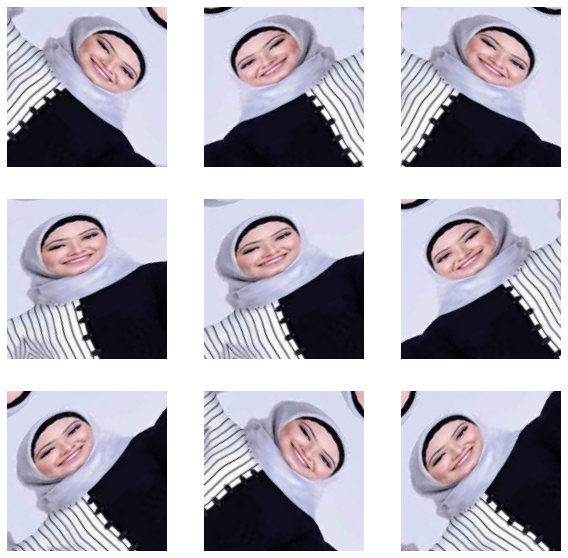

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Изменить масштаб значений пикселей

Мы подготовили данные для загрузки в модель, например, tf.keras.applications.MobileNetV2. 
Эта модель ожидает значений пикселей в [-1,1] ,           но на данный момент значения пикселей в ваших изображениях находятся в [0-255] .              
Чтобы изменить их масштаб,              используем метод предварительной обработки, включенный в модель.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Создайте базовую модель из предварительно обученных сверток
Создадим базовую модель на основе модели MobileNet V2. Это предварительно обученная модель на наборе данных ImageNet,  
состоящем из 1,4 млн изображений и 1000 классов. 

ImageNet - это набор данных для исследовательской подготовки с широким спектром категорий.

Во-первых, нужно выбрать, какой уровень MobileNet V2 мы будем использовать для извлечения функций.         
Самый последний уровень классификации («сверху», поскольку большинство диаграмм моделей машинного обучения идут снизу вверх) не очень полезен. Вместо этого будем следовать общепринятой практике - полагаться на самый последний слой перед операцией выравнивания. 
Этот слой называется «узким местом». Элементы слоя «узкое место» сохраняют большую универсальность по сравнению с последним / верхним слоем.

Сначала создадим экземпляр модели MobileNet V2 с предварительно загруженными весами, обученными в ImageNet. Указав аргумент include_top = False ,  загружаем сеть, которая не включает слои классификации вверху, что идеально подходит для извлечения признаков.



In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

Эта функция экстрактор преобразует каждый 160x160x3 изображение в 5x5x1280 блок функций. 
Давайте посмотрим, что он делает с примером пакета изображений:

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Извлечение признаков
На этом шаге заморозим сверточную базу, созданную на предыдущем шаге, и будем использовать ее в качестве средства извлечения признаков. Кроме того, добавим поверх него классификатор и обучим классификатор верхнего уровня.

### Заморозим сверточные слои базы

Перед компиляцией и обучением модели важно заморозить сверточную базу. Замораживание (путем установки layer.trainable = False) предотвращает обновление весов в данном слое во время обучения. MobileNet V2 имеет много уровней, поэтому установка для trainable флага всей модели значения False заморозит их все

In [17]:
base_model.trainable = False

### Важное примечание о слоях BatchNormalization

Многие модели содержат слои tf.keras.layers.BatchNormalization

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Добавим заголовок классификации

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Применим слой tf.keras.layers.Dense, чтобы преобразовать эти функции в один прогноз для изображения. 
Здесь нам не нужна функция активации, потому что этот прогноз будет рассматриваться как logit или необработанное значение прогноза. Положительные числа предсказывают класс 1, отрицательные числа предсказывают класс 0.

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Создадим модель, объединив вместе слои увеличения, изменения масштаба, base_model и функции извлечения данных, используем training = False, поскольку наша модель содержит слой BatchNormalization.

In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Скомпилируем модель

Скомпилируйте модель перед ее обучением. Поскольку существует два класса, используем двоичную кросс-энтропийную потерю с from_logits=True, поскольку модель обеспечивает линейный вывод

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

Параметры 2,5Х в MobileNet заморожены, но есть 1.2K обучаемых параметров в плотном слое. Они разделены между двумя tf.Variable объектами, весами и смещениями.

In [24]:
len(model.trainable_variables)

2

### Обучим модель

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4937/4937 [==============================] - 4098s 754ms/step - loss: 0.7705 - accuracy: 0.5094


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.51


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
 3295/24684 [===>..........................] - ETA: 4:15:43 - loss: 0.1894 - accuracy: 0.9209

### Кривые обучения

Давайте посмотрим на кривые обучения точности / потери обучения и проверки при использовании базовой модели MobileNet V2 в качестве экстрактора фиксированных функций.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Тонкая настройка
В эксперименте по извлечению признаков мы тренировали только несколько слоев поверх базовой модели MobileNet V2. Веса предварительно обученной сети не обновлялись во время обучения.

Один из способов еще больше повысить производительность - это обучить (или «точно настроить») веса верхних слоев предварительно обученной модели вместе с обучением добавленного нами классификатора. Процесс обучения заставит настраивать веса с общих карт объектов на объекты, связанные специально с набором данных.

### Разморозить верхние слои модели


Кроме того, нам следует попытаться настроить небольшое количество верхних уровней, а не всю модель MobileNet. В большинстве сверточных сетей чем выше уровень, тем он более специализирован. Первые несколько слоев изучают очень простые и общие функции, которые распространяются практически на все типы изображений. По мере того, как мы поднимаемся выше, функции становятся все более специфичными для набора данных, на котором была обучена модель. Цель точной настройки - адаптировать эти специализированные функции для работы с новым набором данных, а не перезаписывать общее обучение.

Разморозить верхние слои модели
Все, что нам нужно сделать, это разморозить base_model и сделать нижние слои base_model . Затем нам следует перекомпилировать модель (необходимо, чтобы эти изменения вступили в силу) и возобновить обучение.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Скомпилируем модель

Поскольку мы тренируем гораздо большую модель и хотим повторно адаптировать предварительно обученные веса, на этом этапе важно использовать более низкую скорость обучения. В противном случае наша модель может очень быстро переобучиться

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

### Продолжим обучение модели

этот шаг повысит нашу точность на несколько процентов.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Давайте посмотрим на кривые обучения точности / потери обучения и проверки при тонкой настройке последних нескольких уровней базовой модели MobileNet V2 и обучении классификатора поверх нее. Потеря проверки намного выше, чем потеря тренировки, поэтому мы можем получить некоторое переобучение.

Мы также можем столкнуться с переобучением, поскольку новый обучающий набор относительно невелик и похож на исходные наборы данных MobileNet V2.

После точной настройки модель достигает почти высокого процента точности точности на проверочном наборе.


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Оценка и прогноз

Наконец, мы можем проверить работоспособность модели на новых данных с помощью набора тестов.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

И теперь мы готовы использовать эту модель, чтобы предсказать, изображена ли на картинке женщина в хиджабе или не она.

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")